In [17]:
import os
import sys

libs_dir = os.path.join("/".join(os.getcwd().split("/")[:-2]))
sys.path.append(libs_dir)

import numpy as np
import matplotlib.pyplot as plt
from libs.figure_config import *
import matplotlib.patches as patches
from libs.satellite import *

In [18]:
satellite_1293 = LEOsatellite(
    libs_dir + '/data/STARLINK_1293.txt')
location_aizu = np.loadtxt(
    libs_dir + '/data/ogs_loc.txt')
location_sendai = np.loadtxt(
    libs_dir + '/data/ogs_loc_sendai.txt')
year = 2021
day = 357
hour = 16
minute = 29

t = np.arange(0, 241, 10) 
second = 56 + t 
utc = 9

latitude_bob = location_aizu[:, 0]
longitude_bob = location_aizu[:, 1]
elevation_bob = location_aizu[:, 2]

latitude_alice = location_sendai[:, 0]
longitude_alice = location_sendai[:, 1]
elevation_alice = location_sendai[:, 2]

# Bob用のリスト
# Location: Sendai
slant_path_bob_lst = np.zeros(len(second))
zenith_angle_bob_lst = np.zeros(len(second))

# Alice用のリスト
# Location: Aizuwakamatsu
slant_path_alice_lst = np.zeros(len(second))
zenith_angle_alice_lst = np.zeros(len(second))

for idx in range(len(second)):
    # slant_path_lst[idx], zenith_angle_lst[idx] = satellite_1293.computeGeometricWithUser(
    #     year, day, hour, minute, second[idx], utc,
    #     longitude[idx], latitude[idx], elevation[idx]
    slant_path_bob_lst[idx], zenith_angle_bob_lst[idx] = satellite_1293.computeGeometricWithUser(
        year, day, hour, minute, second[idx], utc,
        longitude_bob[0], latitude_bob[0], elevation_bob[0] # bobが単一の場合、[0]でアクセス
    )

    slant_path_alice_lst[idx], zenith_angle_alice_lst[idx] = satellite_1293.computeGeometricWithUser(
        year, day, hour, minute, second[idx], utc,
        longitude_alice[0], latitude_alice[0], elevation_alice[0]
    )

slant_path_bob_lst = slant_path_bob_lst * 1000
slant_path_alice_lst = slant_path_alice_lst * 1000

In [23]:
qber_simul = np.load('results/qber_siml_bbm92_test1_n_s05_v2.npy')
skr_simul = np.load('results/skr_siml_bbm92_test1_n_s05_v2.npy')
skr_simul_jitter4 = np.load('results/skr_siml_bbm92_test1_yudai_n_s05_jitter4.npy')
# qber_analysis = np.load('results/qber_analysis_bbm92_test1_n_s05.npy')

qber_analysis = np.load('results/qber_analysis_bbm92_test1_yudai_n_s05.npy')
skr_analysis = np.load('results/skr_analysis_bbm92_test1_yudai_n_s05.npy')
skr_analysis_jitter4 = np.load('results/skr_analysis_bbm92_test1_yudai_n_s05_jitter4.npy')

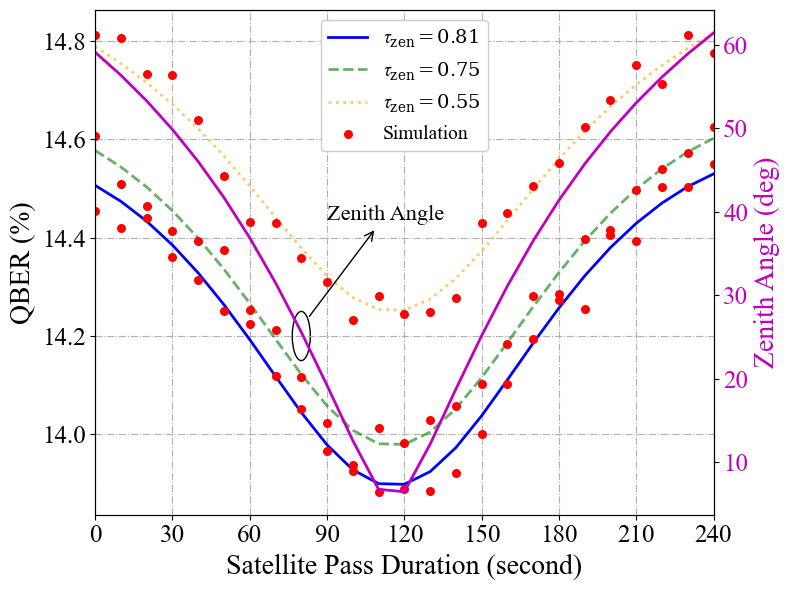

In [65]:
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(t, qber_analysis[0][:]*100, label=r'$\tau_{\rm zen} = 0.81$', color='blue')
ax1.plot(t, qber_analysis[1][:]*100, ls='--', label=r'$\tau_{\rm zen} = 0.75$', color='green', alpha=0.6)
ax1.plot(t, qber_analysis[2][:]*100, ls=':', label=r'$\tau_{\rm zen} = 0.55$', color='orange', alpha=0.6)


ax1.scatter(t, qber_simul[0][:]*100, marker='o', c='red', s=30, linewidths=1, zorder=2, label='Simulation')
ax1.scatter(t, qber_simul[1][:]*100, marker='o', c='red', s=30, linewidths=1, zorder=2)
ax1.scatter(t, qber_simul[2][:]*100, marker='o', c='red', s=30, linewidths=1, zorder=2)


ax1.set_xlabel(r'Satellite Pass Duration (second)')
ax1.set_ylabel(r"QBER (%)")

ax1.set_xlim(0, 240)


ellipse = patches.Ellipse((80, 14.2), width=7, height=0.1, edgecolor='black', facecolor='none', lw=1)
ax1.add_patch(ellipse)

# 楕円のパラメータ
a = 7 / 2
b = 0.1 / 2
angle = np.pi / 4

# 楕円の外周上の矢印ターゲット座標（対角方向）
arrow_target_x = 80 + a * np.cos(angle)
arrow_target_y = 14.2 + b * np.sin(angle)

# 矢印とラベルの追加
ax1.annotate(
    r'Zenith Angle',
    xy=(arrow_target_x, arrow_target_y),
    xytext=(90, arrow_target_y + 0.2),  # ラベル位置
    arrowprops=dict(arrowstyle='<-', color='black', lw=1),
    fontsize=16,
    color='black'
)

ax2 = ax1.twinx()
ax2.plot(t, zenith_angle_bob_lst, color='m', linewidth=2)
ax2.set_ylabel(r"Zenith Angle (deg)", color='m')
ax2.tick_params(axis='y', labelcolor='m')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines1 + lines2, 
    labels1 + labels2, 
    loc='upper center',
    fontsize=14)

ax1.grid()
plt.tight_layout()
_ = plt.xticks(np.arange(0, 241, 30))
# plt.title('QBER and Zenith Angle during Satellite Pass (n_s=0.5)', fontsize=20)
plt.savefig('figure_results/qber_sat_pass_test1_n_s5.pdf', format='pdf', bbox_inches="tight")

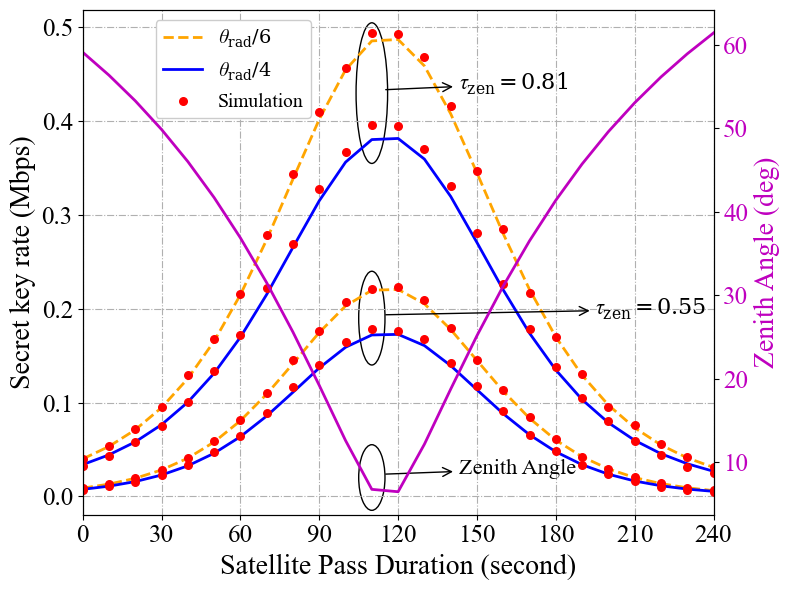

In [24]:
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(t, skr_analysis[0][:]/10**6, ls='--', c='orange', label=r'$\theta_{\mathrm{rad}}/6$')
# ax1.plot(t, skr_analysis[1][:]/10**6, ls='--', label=r'$\tau_{\rm zen} = 0.75$')
ax1.plot(t, skr_analysis[2][:]/10**6, ls='--', c = 'orange')

# jitter4
ax1.plot(t, skr_analysis_jitter4[0][:]/10**6, ls='-', c='blue', label=r'$\theta_{\mathrm{rad}}/4$')
# ax1.plot(t, skr_analysis_jitter4[1][:]/10**6, ls='--', label=r'$\tau_{\rm zen} = 0.75$ (jitter4)')
ax1.plot(t, skr_analysis_jitter4[2][:]/10**6, ls='-', c='blue')

ax1.scatter(t, skr_simul[0][:]/10**6, marker='o', c='red', s=30, linewidths=1, zorder=2, label='Simulation')
# ax1.scatter(t, skr_simul[1][:]/10**6, marker='o', c='red', s=30, linewidths=1, zorder=2)
ax1.scatter(t, skr_simul[2][:]/10**6, marker='o', c='red', s=30, linewidths=1, zorder=2)

ax1.scatter(t, skr_simul_jitter4[0][:]/10**6, marker='o', c='red', s=30, linewidths=1, zorder=2)

ax1.scatter(t, skr_simul_jitter4[1][:]/10**6, marker='o', c='red', s=30, linewidths=1, zorder=2)

ax1.set_xlabel(r'Satellite Pass Duration (second)')
ax1.set_ylabel(r"Secret key rate (Mbps)")

ax1.set_xlim(0, 240)

ellipse_zen = patches.Ellipse((110, 0.02), width=10, height=0.07, edgecolor='black', facecolor='none', lw=1)
ax1.add_patch(ellipse_zen)
arrow_target_x_2 = 110  + (12/2) * np.cos(np.pi / 4)  # width方向の半径 * cos(45°)
arrow_target_y_2 = 0.02 + (0.01/2) * np.sin(np.pi / 4)  # height方向の半径 * sin(45°)

# 矢印とラベルの追加
ax1.annotate(
   r'Zenith Angle',
    xy=(arrow_target_x_2, arrow_target_y_2),
    xytext=(143, arrow_target_y_2),  # ラベル位置
    arrowprops=dict(arrowstyle='<-', color='black', lw=1),
    fontsize=16,
    color='black'
)


ellipse_zen = patches.Ellipse((110, 0.43), width=12, height=0.15, edgecolor='black', facecolor='none', lw=1)
ax1.add_patch(ellipse_zen)
arrow_target_x_2 = 110  + (12/2) * np.cos(np.pi / 4)  # width方向の半径 * cos(45°)
arrow_target_y_2 = 0.43 + (0.01/2) * np.sin(np.pi / 4)  # height方向の半径 * sin(45°)

# 矢印とラベルの追加
ax1.annotate(
   r'$\tau_{\mathrm{zen}} = 0.81$',
    xy=(arrow_target_x_2, arrow_target_y_2),
    xytext=(143, arrow_target_y_2),  # ラベル位置
    arrowprops=dict(arrowstyle='<-', color='black', lw=1),
    fontsize=16,
    color='black'
)

# tau_zen = 0.53
ellipse2 = patches.Ellipse((110, 0.19), width=10, height=0.1, edgecolor='black', facecolor='none', lw=1)
ax1.add_patch(ellipse2)
arrow_target_x_2 = 110 + (12/2) * np.cos(np.pi / 4)  # width方向の半径 * cos(45°)
arrow_target_y_2 = 0.19 + (0.01/2) * np.sin(np.pi / 4)  # height方向の半径 * sin(45°)

# 矢印とラベルの追加
ax1.annotate(
   r'$\tau_{\mathrm{zen}} = 0.55$',
    xy=(arrow_target_x_2, arrow_target_y_2),
    xytext=(195, arrow_target_y_2),  # ラベル位置
    arrowprops=dict(arrowstyle='<-', color='black', lw=1),
    fontsize=16,
    color='black'
)

ax2 = ax1.twinx()
ax2.plot(t, zenith_angle_bob_lst, color='m', linewidth=2)
ax2.set_ylabel(r"Zenith Angle (deg)", color='m')
ax2.tick_params(axis='y', labelcolor='m')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines1 + lines2, 
    labels1 + labels2, 
    loc='upper left',
    bbox_to_anchor=(0.1, 1.0),
    fontsize=14)

ax1.grid()
plt.tight_layout()
_ = plt.xticks(np.arange(0, 241, 30))
plt.savefig(f'figure_results/skr_sat_pass_comp_jitter.pdf', format='pdf', bbox_inches="tight")